In [1]:
import os
os.environ['R_HOME'] = '/usr/lib/R'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.chdir('/home/wcy/code/pyFile/RIFF_package/v1107/')
import warnings
warnings.filterwarnings("ignore")
import argparse
import logging
logging.getLogger('rpy2').setLevel(logging.WARNING)

import pandas as pd
from sklearn.metrics import adjusted_rand_score

import Riff

# 1. Set Parameters

In [2]:
parser = argparse.ArgumentParser(description="GAT")
parser.add_argument("--seeds", type=int, default=0)
parser.add_argument("--device", type=int, default=4)
parser.add_argument("--warmup_steps", type=int, default=-1)
parser.add_argument("--num_heads", type=int, default=4, help="number of hidden attention heads")
parser.add_argument("--num_out_heads", type=int, default=1, help="number of output attention heads")
parser.add_argument("--residual", action="store_true", default=False, help="use residual connection")
parser.add_argument("--in_drop", type=float, default=0.2, help="input feature dropout")
parser.add_argument("--attn_drop", type=float, default=0.1, help="attention dropout")
parser.add_argument("--weight_decay", type=float, default=2e-4, help="weight decay")
parser.add_argument("--negative_slope", type=float, default=0.2, help="the negative slope of leaky relu for GAT")
parser.add_argument("--drop_edge_rate", type=float, default=0.0)
parser.add_argument("--optimizer", type=str, default="adam")
parser.add_argument("--lr_f", type=float, default=0.01, help="learning rate for evaluation")
parser.add_argument("--weight_decay_f", type=float, default=1e-4, help="weight decay for evaluation")
parser.add_argument("--linear_prob", action="store_true", default=True)
parser.add_argument("--load_model", action="store_true")
parser.add_argument("--save_model", action="store_true")
parser.add_argument("--use_cfg", action="store_true")
parser.add_argument("--logging", action="store_true")
parser.add_argument("--scheduler", action="store_true", default=True)


parser.add_argument("--pooling", type=str, default="mean")
parser.add_argument("--deg4feat", action="store_true", default=False, help="use node degree as input feature")
parser.add_argument("--batch_size", type=int, default=32)


parser.add_argument("--encoder", type=str, default="gin")
parser.add_argument("--decoder", type=str, default="gin")
parser.add_argument("--num_hidden", type=int, default=64, help="number of hidden units")
parser.add_argument("--num_layers", type=int, default=2, help="number of hidden layers")
parser.add_argument("--activation", type=str, default="elu")
parser.add_argument("--max_epoch", type=int, default=200, help="number of training epochs")
parser.add_argument("--lr", type=float, default=0.001, help="learning rate")
parser.add_argument("--alpha_l", type=float, default=4, help="`pow`inddex for `sce` loss")
parser.add_argument("--beta_l", type=float, default=2, help="`pow`inddex for `weighted_mse` loss")   
parser.add_argument("--loss_fn", type=str, default="weighted_mse")
parser.add_argument("--mask_gene_rate", type=float, default=0.8)
parser.add_argument("--replace_rate", type=float, default=0.05)
parser.add_argument("--remask_rate", type=float, default=0.5)
parser.add_argument("--warm_up", type=int, default=50)
parser.add_argument("--norm", type=str, default="batchnorm")

# Riff parameter
parser.add_argument("--num_neighbors", type=int, default=7)
parser.add_argument("--confidence_threshold", type=float, default=3e-3)
parser.add_argument("--pre_aggregation", type=int, default=[1, 1])
parser.add_argument("--min_pseudo_label", type=int, default=3000)
parser.add_argument("--num_features", type=int, default=3000)
parser.add_argument("--seq_tech", type=str, default="Visium")
parser.add_argument("--sample_name", type=str, default="151674")
parser.add_argument("--cluster_label", type=str, default= "layer_guess")
parser.add_argument("--folder_name", type=str, default="/home/wcy/code/datasets/Visium/DLPFC")  
parser.add_argument("--num_classes", type=int, default=7, help = "The number of clusters")
parser.add_argument("--top_num", type=int, default=10)
parser.add_argument("--radius", type=int, default=50)
parser.add_argument("--output_folder", type=str, default="/home/wcy/code/pyFile/RIFF_package/v1107/output")

args = parser.parse_args(args=['--sample_name', '151674']) 
args.device = args.device if args.device >= 0 else "cpu"
args

Namespace(activation='elu', alpha_l=4, attn_drop=0.1, batch_size=32, beta_l=2, cluster_label='layer_guess', confidence_threshold=0.003, decoder='gin', deg4feat=False, device=4, drop_edge_rate=0.0, encoder='gin', folder_name='/home/wcy/code/datasets/Visium/DLPFC', in_drop=0.2, linear_prob=True, load_model=False, logging=False, loss_fn='weighted_mse', lr=0.001, lr_f=0.01, mask_gene_rate=0.8, max_epoch=200, min_pseudo_label=3000, negative_slope=0.2, norm='batchnorm', num_classes=7, num_features=3000, num_heads=4, num_hidden=64, num_layers=2, num_neighbors=7, num_out_heads=1, optimizer='adam', output_folder='/home/wcy/code/pyFile/RIFF_package/v1107/output', pooling='mean', pre_aggregation=[1, 1], radius=50, remask_rate=0.5, replace_rate=0.05, residual=False, sample_name='151674', save_model=False, scheduler=True, seeds=0, seq_tech='Visium', top_num=10, use_cfg=False, warm_up=50, warmup_steps=-1, weight_decay=0.0002, weight_decay_f=0.0001)

# 2. Preprocession

***Note: Change the folder path to read your own dataset *** ^_^

1. An example to read data stored like: expression/spatial info/metadata in .tsv file:  
    ```adata = Riff.Read_Stereoseq(data_path) ``` 

2. An example to read data stored like: expression/metadata in .txt file, spatial info in .csv file:  
    ```adata = Riff.Read_SlideseqV2(data_path)  ``` 

3. An example to read standard 10x Xenium data:  
    ```h5_path = os.path.join(args.folder_name, args.sample_name, "cell_feature_matrix.h5")```  
    ```obs_path = os.path.join(args.folder_name, args.sample_name, "cells.csv")```  
    ```adata = Riff.Read_Xenium(h5_path, obs_path)```

In [3]:
data_path = os.path.join(args.folder_name, args.sample_name)
adata = Riff.Read_Visium_with_label(data_path)                                    # Read standard 10x Visium data

In [4]:
if(args.cluster_label != ""):
    args.num_classes = adata.obs[args.cluster_label].nunique()
    adata.obs[args.cluster_label] = adata.obs[args.cluster_label].astype('category')

adata = Riff.Preprocess_adata(args, adata)
adata, graph = Riff.Build_graph(args, adata, spatial_key='image_coor')
adata = Riff.Generate_pseudo_label(args, adata, graph)
adata

=================== Contructing graph =====================
================== Generating pseudo-label ================
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%


AnnData object with n_obs × n_vars = 3673 × 3000
    obs: 'barcode', 'sample_name', 'tissue', 'row', 'col', 'imagerow', 'imagecol', 'Cluster', 'height', 'width', 'sum_umi', 'sum_gene', 'subject', 'position', 'replicate', 'subject_position', 'discard', 'key', 'cell_count', 'SNN_k50_k4', 'SNN_k50_k5', 'SNN_k50_k6', 'SNN_k50_k7', 'SNN_k50_k8', 'SNN_k50_k9', 'SNN_k50_k10', 'SNN_k50_k11', 'SNN_k50_k12', 'SNN_k50_k13', 'SNN_k50_k14', 'SNN_k50_k15', 'SNN_k50_k16', 'SNN_k50_k17', 'SNN_k50_k18', 'SNN_k50_k19', 'SNN_k50_k20', 'SNN_k50_k21', 'SNN_k50_k22', 'SNN_k50_k23', 'SNN_k50_k24', 'SNN_k50_k25', 'SNN_k50_k26', 'SNN_k50_k27', 'SNN_k50_k28', 'GraphBased', 'Maynard', 'Martinowich', 'Layer', 'layer_guess', 'layer_guess_reordered', 'layer_guess_reordered_short', 'expr_chrM', 'expr_chrM_ratio', 'SpatialDE_PCA', 'SpatialDE_pool_PCA', 'HVG_PCA', 'pseudobulk_PCA', 'markers_PCA', 'SpatialDE_UMAP', 'SpatialDE_pool_UMAP', 'HVG_UMAP', 'pseudobulk_UMAP', 'markers_UMAP', 'SpatialDE_PCA_spatial', 'SpatialDE

# 3. Training and spatial domain identification

In [5]:
adata, _ = Riff.Train(args, adata, graph) 

==================== Building model ====================
==================== Start training ====================


# Epoch 199: train_loss: 0.02: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:16<00:00, 12.07it/s]


Trained model saved to /home/wcy/code/pyFile/RIFF_package/v1107/output/model/151674.pth


In [6]:
adata, new_key = Riff.Ensemble_clustering(adata, args.radius, args.num_classes, args.top_num)

=================== Combining Result ===================
Try new radius! Result is stored in 'combined_refine_7'.


# 4. Evaluation

In [7]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score

... storing 'subject' as categorical
... storing 'subject_position' as categorical
... storing 'Maynard' as categorical
... storing 'Martinowich' as categorical
... storing 'layer_guess_reordered' as categorical
... storing 'layer_guess_reordered_short' as categorical
... storing 'pred1_refine' as categorical
... storing 'pred2_refine' as categorical
... storing 'combined_refine' as categorical
... storing 'combined_refine_37' as categorical
... storing 'combined_refine_19' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


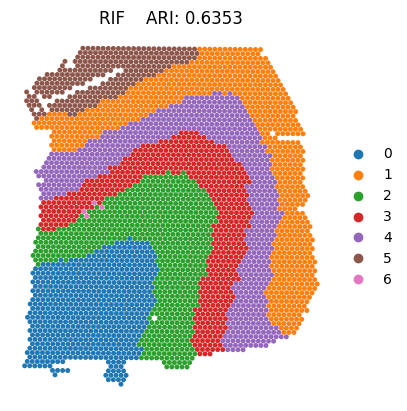

In [8]:
adata_reduce = adata[~pd.isnull(adata.obs[args.cluster_label])]
ari = adjusted_rand_score(adata_reduce.obs[args.cluster_label], adata_reduce.obs[new_key])
adata_reduce.obs[new_key] = adata_reduce.obs[new_key].astype('category')
title = 'RIF    ' + "ARI: " + str(round(ari, 4))
sc.pl.embedding(adata_reduce, basis='spatial', color=new_key, title=title, s=50, show=False)
plt.gca().set_aspect(1)
plt.axis('off')
plt.gca().invert_yaxis()
plt.show()

# 3. UMAP and PAGA

... storing 'subject' as categorical
... storing 'subject_position' as categorical
... storing 'Maynard' as categorical
... storing 'Martinowich' as categorical
... storing 'layer_guess_reordered' as categorical
... storing 'layer_guess_reordered_short' as categorical
... storing 'pred1_refine' as categorical
... storing 'pred2_refine' as categorical
... storing 'combined_refine' as categorical
... storing 'combined_refine_37' as categorical
... storing 'combined_refine_19' as categorical
... storing 'combined_refine_7' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


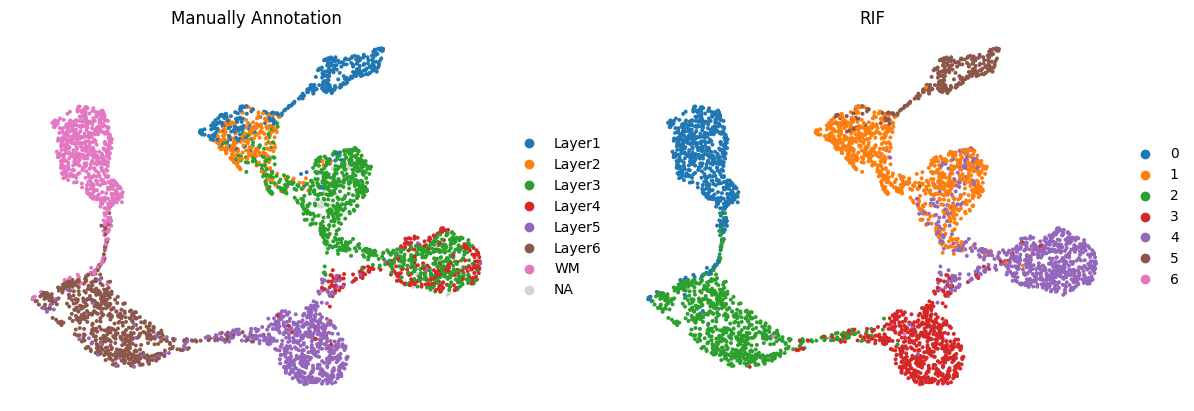

In [9]:
sc.pp.neighbors(adata, use_rep='Riff_embedding')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['layer_guess', new_key], title=['Manually Annotation', 'RIF'], frameon=False)

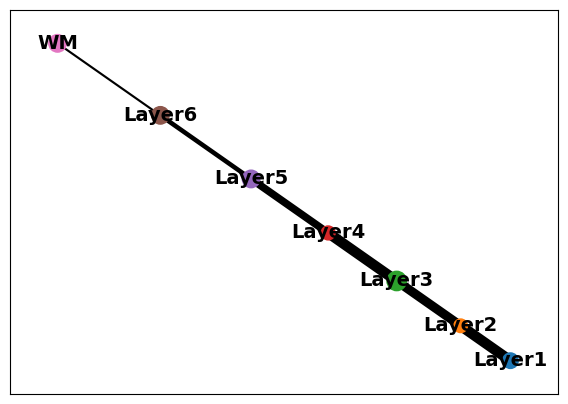

In [10]:
sc.pp.neighbors(adata_reduce, use_rep='Riff_embedding')
sc.tl.paga(adata_reduce, groups='layer_guess')
sc.pl.paga(adata_reduce, fontsize=14)

# 4. Save as .h5ad file for SVG detection

In [11]:
if args.output_folder is not None:
    adata.write_h5ad(args.output_folder + '/adata/' + args.sample_name + '.h5ad')
    print("adata saved to " + args.output_folder + '/adata/' + args.sample_name + '.h5ad')

adata saved to /home/wcy/code/pyFile/RIFF_package/v1107/output/adata/151674.h5ad
